In [60]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [31]:
ex = experiment.PairExperiment(
    Path('/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47'),
    'TL/470/410/470/410',
    register=False
).full_pipeline()

09:30:04 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:30:04 INFO:Segmenting pharynxes
09:30:06 INFO:Centering and rotating pharynxes


09:30:15 INFO:Calculating midlines


09:30:16 INFO:Measuring under midlines


09:30:18 INFO:Trimming intensity data


09:30:18 INFO:Calculating redox measurements
09:30:18 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:30:18 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-16_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
09:30:19 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-16_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-profile_data.nc
09:30:19 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47


In [385]:
reload(utils);
shifted_meas, shifts, orig_idx = utils.measure_shifted_midlines(ex, (-2, 2), 5)
# reg_shifted = profile_processing.register_profiles(shifted_meas)

In [431]:
r0 = shifted_meas.sel(wavelength='410', pair=0) / shifted_meas.sel(wavelength='470', pair=0)
r1 = shifted_meas.sel(wavelength='410', pair=1) / shifted_meas.sel(wavelength='470', pair=1)
rr = r0 / r1
err_raw = np.abs(1 - rr)
df_raw = pd.DataFrame(np.array([orig_idx, shifts, np.mean(err, axis=1)]).T, columns=['orig_idx', 'shift', 'err'])
df_raw['strategy'] = 'raw'

reg_data = reg_shifted.reg_data
r0 = reg_data.sel(wavelength='410', pair=0) / reg_data.sel(wavelength='470', pair=0)
r1 = reg_data.sel(wavelength='410', pair=1) / reg_data.sel(wavelength='470', pair=1)
rr = r0 / r1
err_reg = np.abs(1 - rr)
df_reg = pd.DataFrame(np.array([orig_idx, shifts, np.mean(err, axis=1)]).T, columns=['orig_idx', 'shift', 'err'])
df_reg['strategy'] = 'reg'

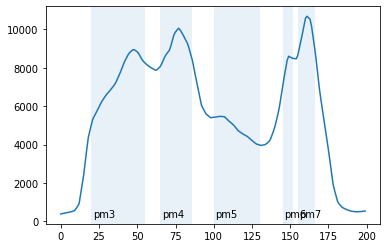

In [459]:
fig, ax = plt.subplots()
ax.plot(np.mean(shifted_meas[0,1], axis=0))
regions = {
    'pm3': (20, 55),
    'pm4': (65, 86),
    'pm5': (100, 130),
    'pm6': (145, 152),
    'pm7': (155, 166)
}
plots.add_regions_to_axis(ax=ax, regions=regions)

In [624]:
region_err_raw = profile_processing.summarize_over_regions(err_raw, regions)
region_err_raw['strategy'] = 'raw'
region_err_raw['shift'] = df_raw['shift']
region_err_reg = profile_processing.summarize_over_regions(err_reg, regions)
region_err_reg['strategy'] = 'reg'
region_err_reg['shift'] = df_reg['shift']

region_err = pd.concat([region_err_raw, region_err_reg])

region_err.columns = ['error', 'region', 'animal', 'strategy', 'shift']
region_err.to_csv('../../data/figures/region_errors.csv')
region_err

,error,region,animal,strategy,shift
0,0.136886,pm3,0,raw,-2.0
1,0.058003,pm3,1,raw,-1.0
2,0.000000,pm3,2,raw,0.0
3,0.045517,pm3,3,raw,1.0
4,0.088244,pm3,4,raw,2.0
...,...,...,...,...,...
1020,0.007837,pm7,1020,reg,-2.0
1021,0.004038,pm7,1021,reg,-1.0
1022,0.000000,pm7,1022,reg,0.0
1023,0.004400,pm7,1023,reg,1.0


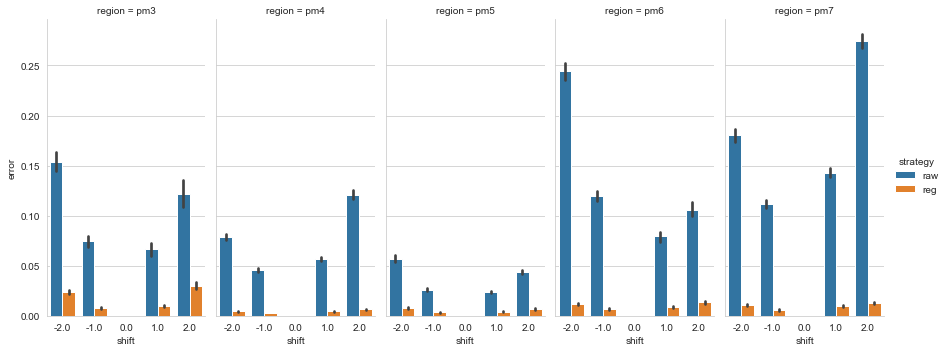

In [627]:
sns.set_style('whitegrid')
sns.catplot(
    x='shift',
    y='error',
    hue='strategy',
    data=region_err,
    kind='bar',
    col='region',
#     col_wrap=2,
#     height=3,
    aspect=.5
)
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/raw_v_reg_bar.pdf')

In [614]:
def cdf_by_shift(data, display_median_line=False, **kwargs):
    sorted_data = np.sort(data)
    cdf = plt.step(sorted_data, np.arange(sorted_data.size) / sorted_data.size, **kwargs)[0]
    if display_median_line:
        plt.axhline()
        plt.axvline(np.median(sorted_data), ymax=.5, color=cdf.get_color())

In [633]:
def cdf_by_region_and_shift(data, title=None, **facet_kwargs):
    sns.set(style="whitegrid")
    a = sns.FacetGrid(data, 
                      hue="shift", 
                      col="region", 
                      col_wrap=2, 
                      height=4,
                      aspect=1.5,
                      sharex=True,
                      legend_out=True,
                      **facet_kwargs)
    a = (a.map(lambda x, **kwargs: cdf_by_shift(x, display_median_line=False, **kwargs), "error")).add_legend()

    if title is not None:
        plt.gcf().subplots_adjust(top=0.93)
        plt.gcf().suptitle(title, fontsize=20)
    return a

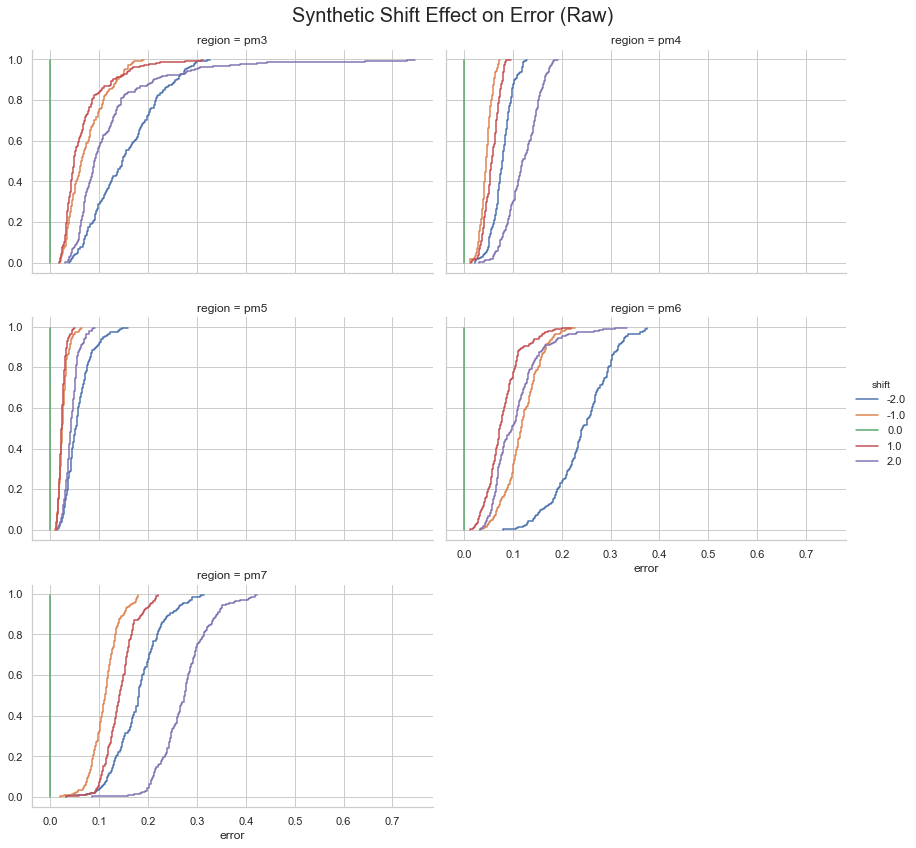

In [634]:
data = region_err[region_err['strategy'] == 'raw']
cdf_by_region_and_shift(data, title='Synthetic Shift Effect on Error (Raw)')
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/raw_cdf_shift.pdf')

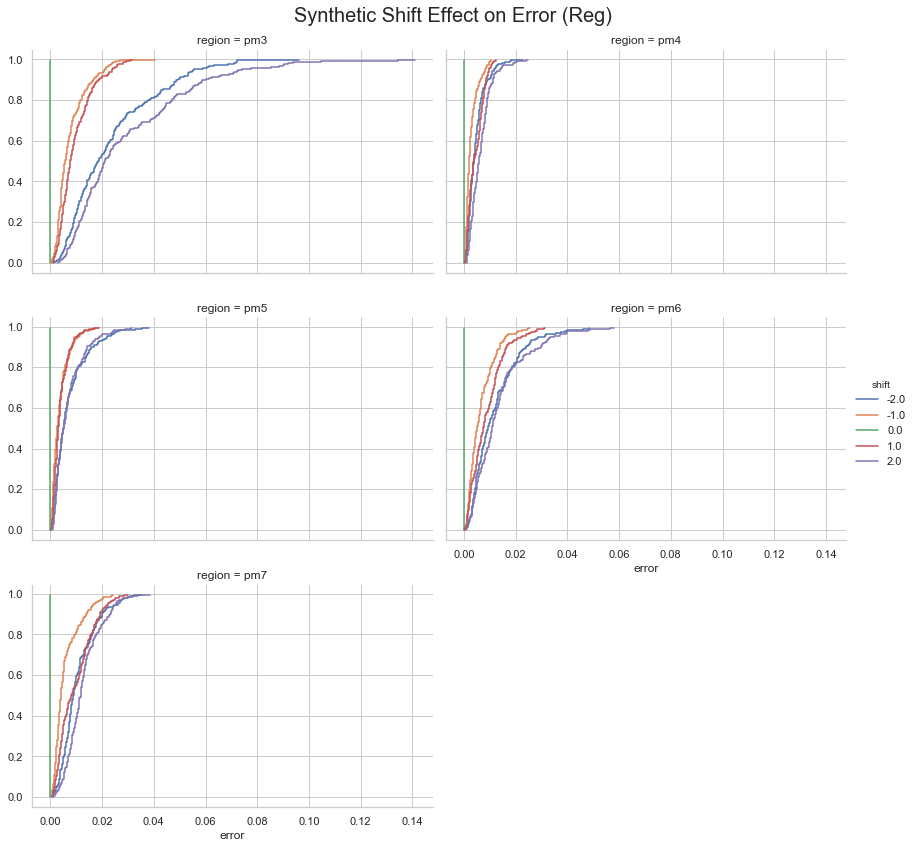

In [630]:
data = region_err[region_err['strategy'] == 'reg']
cdf_by_region_and_shift(data, title='Synthetic Shift Effect on Error (Reg)')
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/reg_cdf_shift.pdf')